## Compute Sagnac Frequency - Backscatter Correction - Frequency Domain

## Imports

In [53]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# test U
config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 02:00")

# test V
config['tbeg'] = UTCDateTime("2024-05-22 16:00")
config['tend'] = UTCDateTime("2024-05-22 19:00")

config['rings'] = {"U":303, "V":447.5, "W":447.5, "Z":553}

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


In [4]:
def __load_romy_raw_data(seed, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime


    print(f" -> loading {seed}...")

    try:
        st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
    except:
        print(f" -> failed for {seed}")

    st0 = st00.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

### Load Archive Files

In [5]:
# sagn = __load_romy_raw_data(f"BW.DROMY..FJ{config['ring']}", config['tbeg'], config['tend'], config['path_to_sds'])
# mon1 = __load_romy_raw_data("BW.DROMY..F1V", config['tbeg'], config['tend'], config['path_to_sds'])
# mon2 = __load_romy_raw_data("BW.DROMY..F2V", config['tbeg'], config['tend'], config['path_to_sds'])

In [6]:
# for ss in [sagn, mon1, mon2]:
#     ss.write(root_path+f"Downloads/mseed/DROMY_{ss[0].stats.channel}_{config['tbeg'].date}.mseed)

### Load Local Files

In [7]:
# sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-19.mseed")
# mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-19.mseed")
# mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-19.mseed")

# sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-01.mseed")
# mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-01.mseed")
# mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-01.mseed")

# sagn.trim(config['tbeg'], config['tbeg']+1800)
# mon1.trim(config['tbeg'], config['tbeg']+1800)
# mon2.trim(config['tbeg'], config['tbeg']+1800)

sagn = read(root_path+f"Downloads/mseed/DROMY_FJ{config['ring']}_{config['tbeg'].date}.mseed")
mon1 = read(root_path+f"Downloads/mseed/DROMY_F1V_{config['tbeg'].date}.mseed")
mon2 = read(root_path+f"Downloads/mseed/DROMY_F2V_{config['tbeg'].date}.mseed")

for st0 in [sagn, mon1, mon2]:
    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


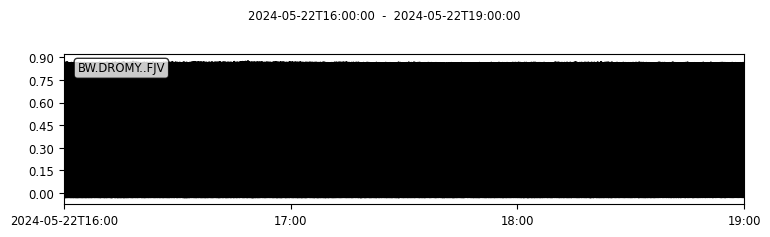

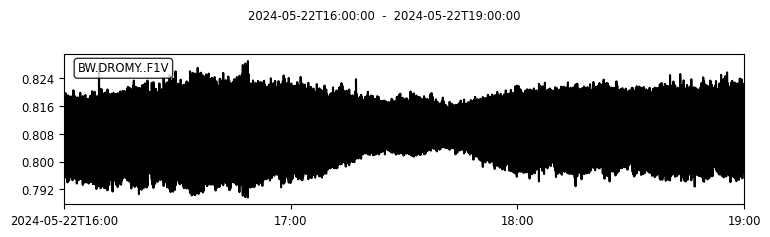

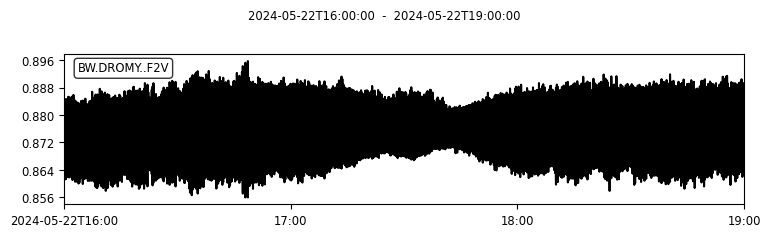

In [8]:
sagn.plot();
mon1.plot();
mon2.plot();

## Processing

In [9]:
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum
from functions.get_time_intervals import __get_time_intervals

In [10]:
def __get_values(ff, psd, pha, f_sagn):

    from numpy import argmax, sqrt, where, argmin, gradient, mean

    ## specify f-band around Sagnac frequency
    fl = f_sagn-2
    fu = f_sagn+2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    DC_est = psd[0]
    # DC_est = psd[0] /2

    ## phase at Sagnac frequency
    ph_est = pha[idx_fs]

    return f_sagn_est, AC_est, DC_est, ph_est

In [11]:
def __get_fft(signal_in, dt, window=None):

    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle

    ## determine length of the input time series
    n = int(len(signal_in))


    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win, norm="forward")

    else:
        spectrum = fft(signal_in, norm="forward")

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)

    ## correct amplitudes of spectrum
    magnitude = 2.0 / n * abs(spectrum)

    ## phase angle
    phase = angle(spectrum, deg=False)

    return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [12]:
def __get_fft_values(signal_in, dt, f_sagn, window=None):

    from numpy import argmax, sqrt, where, argmin, gradient, mean
    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag, unwrap

    ## determine length of the input time series
    n = int(len(signal_in))

    signal_in = fftshift(signal_in)

    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win, norm="forward")

    else:
        spectrum = fft(signal_in, norm="forward")

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)

    ## correct amplitudes of spectrum
    magnitude_corrected = abs(spectrum) *2 /n

    ## none corrected magnitudes
    magnitude = abs(spectrum)

    ## phase spectrum
    phase = angle(spectrum, deg=False)

    freq = frequencies[0:n//2]
    spec = magnitude[0:n//2]
    pha = phase[0:n//2]


    ## specify f-band around Sagnac frequency
    fl = f_sagn - 2
    fu = f_sagn + 2

    ## get index of Sagnac peak
    idx_fs = where(spec == max(spec[(freq > fl) & (freq < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = freq[idx_fs]

    ## estimate AC value at Sagnac peak
    AC_est = spec[idx_fs] * 2

    ## estimate DC value at ff = 0
    DC_est = spec[0]

    ## estimate phase at Sagnac peak
    phase_est = pha[idx_fs] ## select phase of Sagnac

    return f_sagn_est, AC_est, DC_est, phase_est

In [117]:
def __hilbert_frequency_estimator(st, nominal_sagnac, fband, cut=0, plot=False):

    from scipy.signal import hilbert
    import numpy as np

    st0 = st.copy()

    ## extract sampling rate
    df = st0[0].stats.sampling_rate

    ## define frequency band around Sagnac Frequency
    f_lower = nominal_sagnac - fband
    f_upper = nominal_sagnac + fband

    ## bandpass with butterworth around Sagnac Frequency
    st0 = st0.detrend("linear")
    st0 = st0.taper(0.01, type='cosine')
    st0 = st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    if plot:
        x = len(st0[0].data)
        n1, n2 = int(x/2-150),int(x/2+150)
        plt.figure(figsize=(15,5))
        plt.plot(st0[0].data[n1:n2])
        plt.show()

    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data

    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * df)

    ## cut first and last 5% (corrupted data)
    # dd = int(cut*len(instantaneous_frequency))
    dd = int(cut*df)
    insta_f_cut = instantaneous_frequency[dd:-dd]

    # plt.plot(insta_f_cut)

    ## get times
    t = st0[0].times()
    t_mid = t[int((len(t))/2)]

    ## averaging of frequencies
    insta_f_cut_avg = np.mean(insta_f_cut)
    # insta_f_cut_avg = np.median(insta_f_cut)

    return t_mid, insta_f_cut_avg, np.mean(amplitude_envelope), np.std(insta_f_cut)

In [118]:
def __hilbert_frequency_estimator2(st, nominal_sagnac, fband, cut=0):

    from scipy.signal import hilbert
    import numpy as np

    st0 = st.copy()

    ## extract sampling rate
    df = st0[0].stats.sampling_rate

    ## define frequency band around Sagnac Frequency
    f_lower = nominal_sagnac - fband
    f_upper = nominal_sagnac + fband

    ## bandpass with butterworth around Sagnac Frequency
    st0 = st0.detrend("linear")
    st0 = st0.taper(0.01, type='cosine')
    st0 = st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data

    ## calulcate hilbert transform
    hil0 = hilbert(signal)

    ## extract imaginary part of hilbert transform
    hil = np.imag(hil0)

    ## calculate derivatives
    d_hil = np.gradient(hil, edge_order=1)
    d_sig = np.gradient(signal, edge_order=1)

    delta_f_full = (signal * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(signal**2 + hil**2))

    ## extract real part
    instantaneous_frequency = np.real(delta_f_full)

    del hil0, hil, d_hil, d_sig
    ## cut first and last 5% (corrupted data)
    # dd = int(cut*len(instantaneous_frequency))
    dd = int(cut*df)
    insta_f_cut = instantaneous_frequency[dd:-dd]

    ## get times
    t = st0[0].times()
    t_mid = t[int((len(t))/2)]

    ## averaging of frequencies
    # insta_f_cut_avg = np.mean(insta_f_cut)
    insta_f_cut_avg = np.median(insta_f_cut)

    return t_mid, insta_f_cut_avg

## Configurations

In [119]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 60 ## seconds

method = "fft" ## welch | multitaper | fft

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

ddt = 30

fband = 3

## Computing

In [120]:
gc.collect();

0 ...


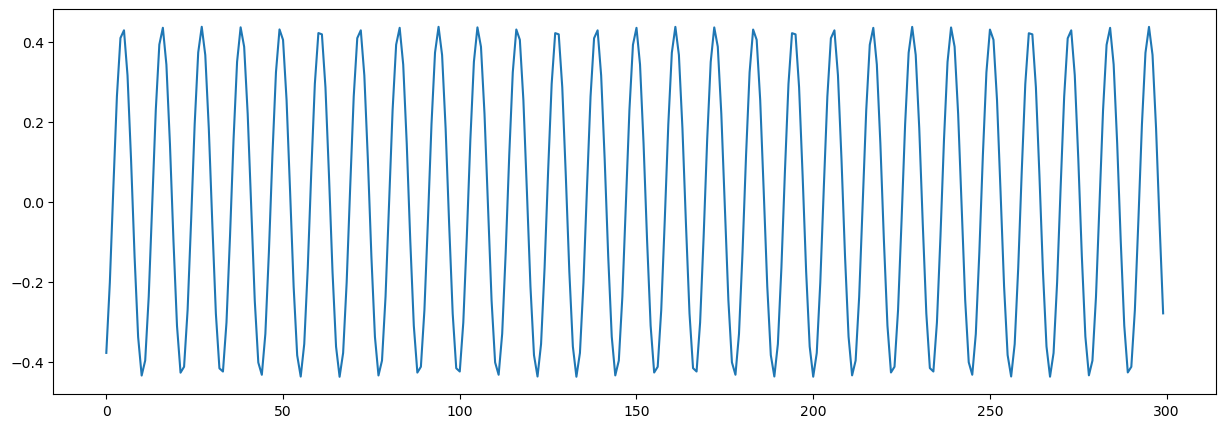

1 ...


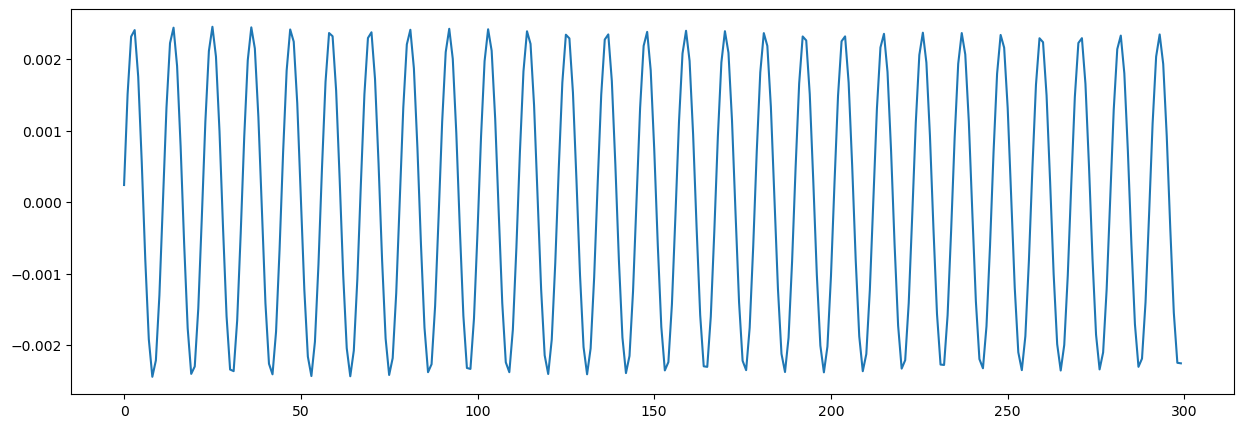

2 ...


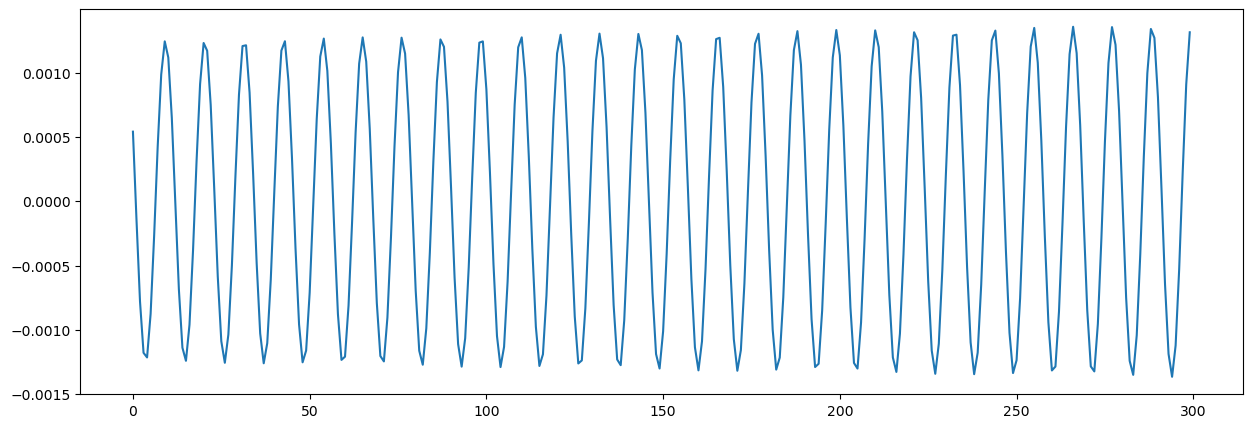

 -> store: 20240522_fft.pkl


In [121]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    print(_k, "...")

    for _n, (t1, t2) in enumerate(times):

        # cut time period with buffer
        _dat = _st.copy().trim(t1-ddt, t2+ddt)

        # compute spectrum
        # f, psd, pha = __get_fft(_dat[0].data, _dat[0].stats.delta, window='hann')

        # extract AC and DC and Phase from spectrum
        # fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, pha, config['rings'][config['ring']])

        # extract AC and DC and Phase from frequency domain
        fs[_n], ac[_n], dc[_n], ph[_n] = __get_fft_values(_dat[0].data,
                                                          _dat[0].stats.delta,
                                                          config['rings'][config['ring']]
                                                         )

        if _n < 1:
            pl = True
        else:
            pl = False

        # hilbert frequency mean estimation
        t, fs[_n], _, _ = __hilbert_frequency_estimator(_dat,
                                                        nominal_sagnac=config['rings'][config['ring']],
                                                        fband=fband,
                                                        cut=ddt,
                                                        plot=pl
                                                       )
        # t, fs[_n] = __hilbert_frequency_estimator2(_dat, nominal_sagnac=config['rings'][config['ring']], fband=50)

        # alternative DC estiamtion in time domain
        # dc[_n] = np.mean(_dat)

    ph = np.unwrap(ph)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph

    gc.collect();

## store data
date_str = f"{config['tbeg'].year}{str(config['tbeg'].month).rjust(2,'0')}{str(config['tbeg'].day).rjust(2,'0')}"
out_df.to_pickle(config['path_to_data']+f"{date_str}_{method}.pkl")
print(f" -> store: {date_str}_{method}.pkl")


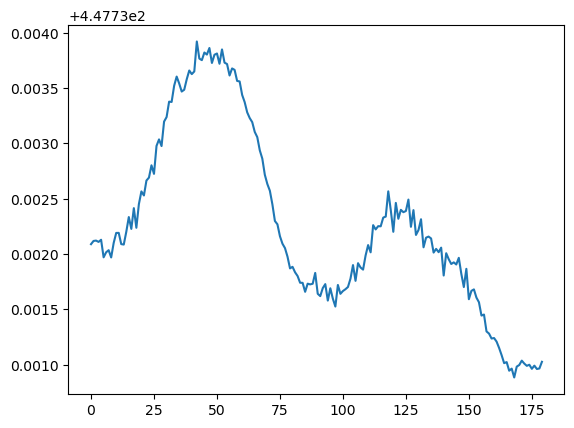

In [122]:
plt.plot(out_df.fj_fs)

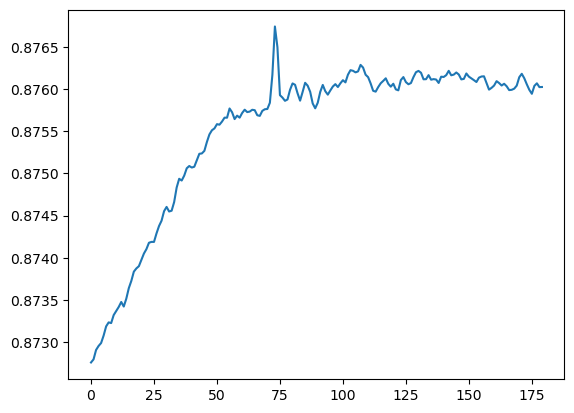

In [123]:
# plt.plot(out_df.f1_dc)

plt.plot(out_df.f2_dc)

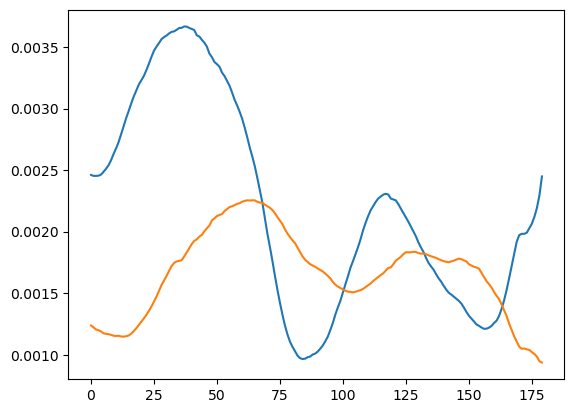

In [124]:
plt.plot(out_df.f1_ac)
plt.plot(out_df.f2_ac)

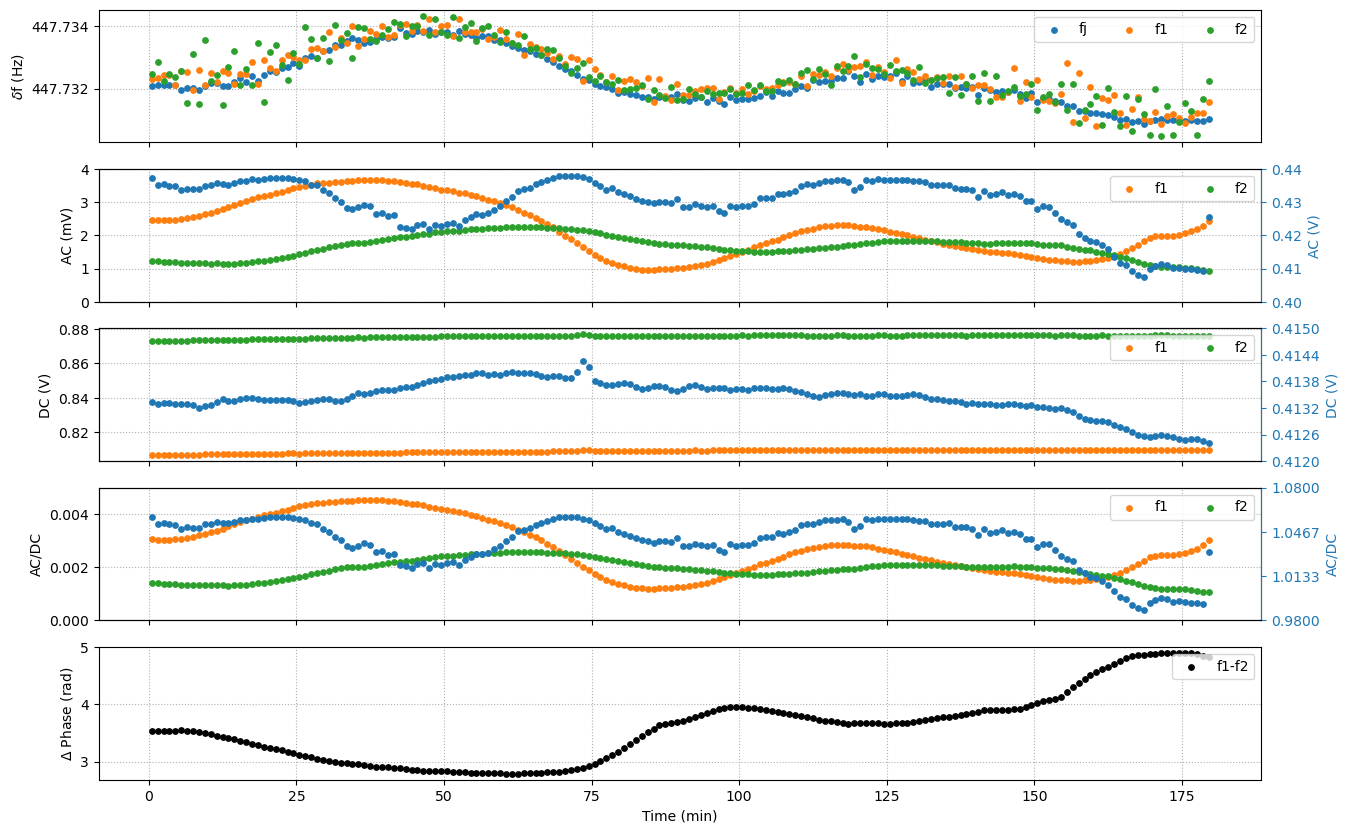

In [125]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    # ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac']*1e3, zorder=2, s=ms, label="f1", color="tab:orange")
    ax[1].scatter(t_axis, df['f2_ac']*1e3, zorder=2, s=ms, label="f2", color="tab:green")
    ax[1].set_ylabel("AC (mV)")
    ax[1].set_ylim(0, 4)

    ax11 = ax[1].twinx()
    ax11.scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax11.set_ylabel("AC (V)")
    ax11.spines['right'].set_color('tab:blue')
    ax11.yaxis.label.set_color('tab:blue')
    ax11.tick_params(axis='y', colors='tab:blue')
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    # ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1", color="tab:orange")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2", color="tab:green")
    ax[2].set_ylabel("DC (V)")
    # ax[2].set_ylim(0.7, 1)

    ax21 = ax[2].twinx()
    ax21.scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax21.set_ylabel("DC (V)")
    ax21.spines['right'].set_color('tab:blue')
    ax21.yaxis.label.set_color('tab:blue')
    ax21.tick_params(axis='y', colors='tab:blue')
    ax21.set_yticks(np.linspace(ax21.get_yticks()[0], ax21.get_yticks()[-1], len(ax[2].get_yticks())))

    # ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1", color="tab:orange")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2", color="tab:green")
    ax[3].set_ylabel("AC/DC")
    ax[3].set_ylim(0, 5e-3)

    ax31 = ax[3].twinx()
    ax31.scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax31.set_ylabel("AC/DC")
    ax31.spines['right'].set_color('tab:blue')
    ax31.yaxis.label.set_color('tab:blue')
    ax31.tick_params(axis='y', colors='tab:blue')
    ax31.set_yticks(np.linspace(ax31.get_yticks()[0], ax31.get_yticks()[-1], len(ax[3].get_yticks())))

    ax[4].scatter(t_axis, df['f1_ph']-df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase (rad)")
    # ax[4].set_yscale("log")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SF_BS_{config['ring']}_{method}_values.png", format="png", dpi=150, bbox_inches='tight')


## Define Quantities for Backscatter Correction

In [110]:
def __backscatter_correction(m01, m02, phase0, w_obs, cm_filter_factor=1.033):

    ## Correct for bias
    m1 = m01 * ( 1 + m01**2 / 4 )
    m2 = m02 * ( 1 + m02**2 / 4 )

    ## angular correction for phase
    phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

    ## compute squares of common-mode modulations
    m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

    ## compute squares of differential-mode modulations
    m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

    ## correct m2c for gain saturation of a HeNe laser
    # m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
    m2c = m2c * cm_filter_factor

    ## compute backscatter correction factor
    M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

    ## correction term
    term = ( 4 + M ) / ( 4 - M )

    ## backscatter correction
    # correction = -1 * ( term -1 ) * 303.05
    # w_corrected = np.array(w_obs) + correction

    w_corrected = np.array(w_obs) * term

    return w_corrected

In [111]:
# fractional beat modulations
m01 = out_df.f1_ac / out_df.f1_dc
m02 = out_df.f2_ac / out_df.f2_dc

# phase difference
phase0 = out_df.f1_ph - out_df.f2_ph

# beat signal observed
w_obs = out_df.fj_fs

## from Ulli
cm_filter_factor = 1.033

## Beat Data

In [112]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [113]:
# t1, t2 = UTCDateTime(out_df['time1'][0]), UTCDateTime(out_df['time1'][0])+len(out_df['time1'])*interval

# # data = __load_beat(t1, t2, config['seed'].split(".")[3][2], config['path_to_data'])
# data = out_df

# w_obs = data['fj_fs']

## Compute Backscatter Correction

In [114]:
w_s = __backscatter_correction(m01, m02, phase0, w_obs, cm_filter_factor=cm_filter_factor)

In [115]:
## Correct for bias
m1 = m01 * ( 1 + m01**2 / 4 )
m2 = m02 * ( 1 + m02**2 / 4 )

## angular correction for phase
phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

## compute squares of common-mode modulations
m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

## compute squares of differential-mode modulations
m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

## correct m2c for gain saturation of a HeNe laser
# m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
m2c = m2c * cm_filter_factor

## compute backscatter correction factor
M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

## correction term
term = ( 4 + M ) / ( 4 - M )

## backscatter correction
# correction = -1 * ( term -1 ) * 303.05
# w_corrected = np.array(w_obs) + correction

w_s = np.array(w_obs) * term


## Plotting

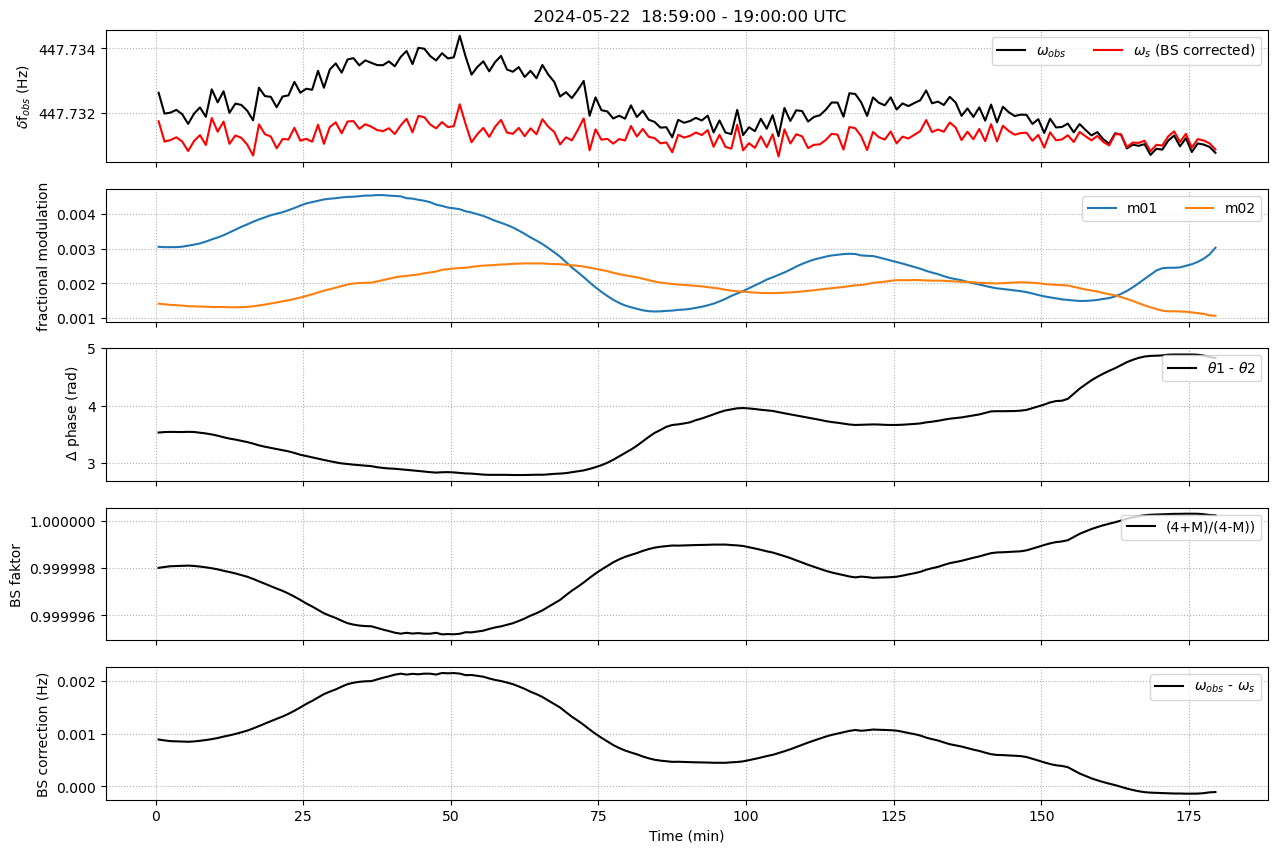

In [116]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(out_df['fj_fs'])))+0.5)*interval/60

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$")
    ax[0].plot(t_axis, w_s, color="r", label="$\omega_{s}$ (BS corrected)")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label=r"$\theta$1 - $\theta$2")
    ax[2].set_ylabel(" $\Delta$ phase (rad)")

    # ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].plot(t_axis, (4+M)/(4-M), color="k", label="(4+M)/(4-M))")
    ax[3].set_ylabel("BS faktor")
    ax[3].ticklabel_format(useOffset=False)

    ax[4].plot(t_axis, w_obs-w_s, color="k", label="$\omega_{obs}$ - $\omega_{s}$")
    # ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")
    ax[4].set_ylabel("BS correction (Hz)")
    ax[4].ticklabel_format(useOffset=False)

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    ax[0].set_title(f" {t1.date}  {str(t1.time).split('.')[0]} - {str(t2.time).split('.')[0]} UTC")

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_{config['ring']}_BS_frequencydomain_{method}_{interval}_{str(t1.date).replace('-',' ')}.png", format="png", dpi=200, bbox_inches='tight')


## Change of CM factor

In [28]:
ws = []
cm = [0.01, 0.1, 1.0, 2.0]
for cm_f_f in cm:
    _ws = __backscatter_correction(m01, m02, phase0, w_obs, cm_filter_factor=cm_f_f)
    ws.append(_ws)

NameError: name 'correction' is not defined

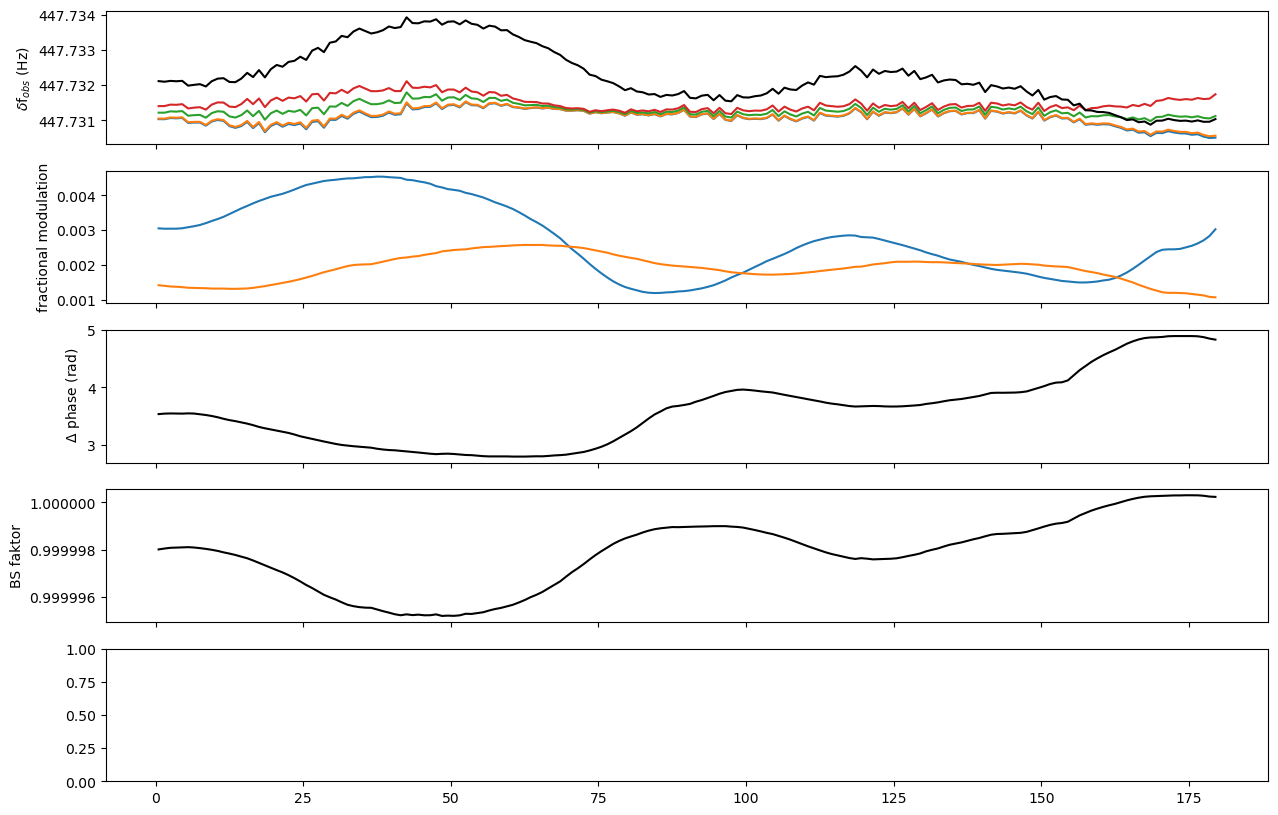

In [29]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(out_df['fj_fs'])))+0.5)*interval/60

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$", zorder=2)
    # ax[0].plot(t_axis, w_s, color="r", label="$\omega_{s}$ = $\omega_{obs}$ - BS correction")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    for _ws, _cm in zip(ws, cm):
        ax[0].plot(t_axis, _ws, label=f"cm={_cm}", zorder=1)


    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label=r"$\theta$1 - $\theta$2")
    ax[2].set_ylabel(" $\Delta$ phase (rad)")

    # ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].plot(t_axis, (4+M)/(4-M), color="k", label="(4+M)/(4-M))")
    ax[3].set_ylabel("BS faktor")
    ax[3].ticklabel_format(useOffset=False)

    ax[4].plot(t_axis, correction, color="k", label="BS correction = ((4+M)/(4-M) -1)*303.05")
    # ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")
    ax[4].set_ylabel("BS correction (Hz)")
    ax[4].ticklabel_format(useOffset=False)

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_frequencyomain_{method}_{interval}_cm_test.png", format="png", dpi=200, bbox_inches='tight')


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import hilbert, chirp
from scipy.signal import get_window
from scipy.signal.windows import dpss

duration = 1.0

fs = 400.0

samples = int(fs*duration)

t = np.arange(samples) / fs

signal = chirp(t, 20.0, t[-1], 100.0)

signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

NN = len(signal)

# win = dpss(NN, 1, Kmax=None, sym=True, norm=None)
win = get_window("cosine", NN)

signal *= win

analytic_signal = hilbert(signal, N=500)

amplitude_envelope = np.abs(analytic_signal)

instantaneous_phase = np.unwrap(np.angle(analytic_signal))

instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)

print(len(amplitude_envelope))
amplitude_envelope = amplitude_envelope[:NN]
instantaneous_phase = instantaneous_phase[:NN]
instantaneous_frequency = instantaneous_frequency[:NN]


fig, (ax0, ax1) = plt.subplots(nrows=2)

ax0.plot(t, signal, label='signal')

ax0.plot(t, amplitude_envelope, label='envelope')

ax0.set_xlabel("time in seconds")

ax0.legend()

ax1.plot(t[1:], instantaneous_frequency[:-1])

ax1.set_xlabel("time in seconds")

ax1.set_ylim(0.0, 120.0)

fig.tight_layout()


In [ ]:
from scipy.signal.windows import dpss

In [ ]:
swin = dpss(NN, 2, Kmax=3, sym=True, norm=None)

In [ ]:
for s in swin:
    plt.plot(s)

In [ ]:
swin[0]